##Imports

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

###Uploading Data to Colab

In [11]:
from google.colab import files # for uploading data_subjects_info.cvs from MotionSense Dataset

# Upload individual files manually
uploaded = files.upload()

Saving data_subjects_info.csv to data_subjects_info (1).csv


In [9]:
from google.colab import files # for uploading A_DeviceMotion_data from MotionSense Dataset

# Upload individual files manually
uploaded = files.upload()

Saving A_DeviceMotion_data.zip to A_DeviceMotion_data.zip


In [20]:
!unzip A_DeviceMotion_data.zip

Archive:  A_DeviceMotion_data.zip
   creating: A_DeviceMotion_data/
   creating: A_DeviceMotion_data/dws_11/
  inflating: A_DeviceMotion_data/dws_11/sub_12.csv  
  inflating: A_DeviceMotion_data/dws_11/sub_1.csv  
  inflating: A_DeviceMotion_data/dws_11/sub_13.csv  
  inflating: A_DeviceMotion_data/dws_11/sub_11.csv  
  inflating: A_DeviceMotion_data/dws_11/sub_2.csv  
  inflating: A_DeviceMotion_data/dws_11/sub_3.csv  
  inflating: A_DeviceMotion_data/dws_11/sub_10.csv  
  inflating: A_DeviceMotion_data/dws_11/sub_14.csv  
  inflating: A_DeviceMotion_data/dws_11/sub_7.csv  
  inflating: A_DeviceMotion_data/dws_11/sub_6.csv  
  inflating: A_DeviceMotion_data/dws_11/sub_15.csv  
  inflating: A_DeviceMotion_data/dws_11/sub_17.csv  
  inflating: A_DeviceMotion_data/dws_11/sub_4.csv  
  inflating: A_DeviceMotion_data/dws_11/sub_5.csv  
  inflating: A_DeviceMotion_data/dws_11/sub_16.csv  
  inflating: A_DeviceMotion_data/dws_11/sub_8.csv  
  inflating: A_DeviceMotion_data/dws_11/sub_9.csv  

In [21]:
print(os.listdir('A_DeviceMotion_data')) #checking my existing paths work fine

['std_14', 'dws_1', 'dws_11', 'jog_16', 'ups_12', 'sit_5', 'std_6', 'ups_4', 'wlk_8', 'wlk_7', 'jog_9', 'dws_2', 'sit_13', 'ups_3', 'wlk_15']


##Loading and Formatting Dataset

In [33]:
def get_ds_infos():
    """
    Loads subject metadata from the dataset.

    Returns:
        dss (pd.DataFrame): DataFrame containing subject attributes (e.g., ID, weight, height, age, gender).
    """
    dss = pd.read_csv("data_subjects_info.csv")  # Load metadata file (must be in the same directory or path must be updated)
    return dss


def set_data_types(data_types=["userAcceleration"]):
    """
    Converts selected sensor types into column names needed for reading the dataset.

    Args:
        data_types (list of str): Sensors to include. Options: ['userAcceleration', 'attitude', 'gravity', 'rotationRate']

    Returns:
        dt_list (list of list): List of columns for each selected sensor type.
    """
    dt_list = []
    for t in data_types:
        if t != "attitude":
            # Add x, y, z components for all but 'attitude'
            dt_list.append([f"{t}.x", f"{t}.y", f"{t}.z"])
        else:
            # 'attitude' uses roll, pitch, yaw instead of x, y, z
            dt_list.append([f"{t}.roll", f"{t}.pitch", f"{t}.yaw"])
    return dt_list


def create_time_series(dt_list, act_labels, trial_codes, mode="raw", labeled=True):
    """
    Loads, filters, and structures the time-series sensor data for all subjects, activities, and trials.

    Args:
        dt_list (list of list): List of selected sensor feature columns, grouped by type.
        act_labels (list of str): Activity labels to include (e.g., ["wlk", "jog"]).
        trial_codes (list of list): Lists of trial IDs per activity.
        mode (str): "raw" to return full x/y/z or roll/pitch/yaw values; "mag" to return magnitude only.
        labeled (bool): Whether to include activity label as last column.

    Returns:
        dataset (pd.DataFrame): Cleaned and labeled time-series dataset.
    """
    # Determine number of columns in final dataset
    num_data_cols = len(dt_list) if mode == "mag" else len(dt_list * 3)

    # Initialize empty dataset: shape = [samples, features (+ label if labeled)]
    dataset = np.zeros((0, num_data_cols + 1)) if labeled else np.zeros((0, num_data_cols))

    # Get list of subject IDs
    ds_list = get_ds_infos()

    # Iterate over all subjects
    for sub_id in ds_list["code"]:
        # For each activity
        for act_id, act in enumerate(act_labels):
            # For each trial of that activity
            for trial in trial_codes[act_id]:
                # Construct file path for current subject's trial
                fname = f'A_DeviceMotion_data/{act}_{trial}/sub_{int(sub_id)}.csv'

                # Read and clean raw data
                raw_data = pd.read_csv(fname).drop(['Unnamed: 0'], axis=1)

                # Initialize array to store selected features
                vals = np.zeros((len(raw_data), num_data_cols))

                # Populate feature array
                for x_id, axes in enumerate(dt_list):
                    if mode == "mag":
                        # Compute magnitude of x, y, z for current sensor
                        vals[:, x_id] = (raw_data[axes]**2).sum(axis=1)**0.5
                    else:
                        # Store x, y, z or roll, pitch, yaw directly
                        vals[:, x_id*3:(x_id+1)*3] = raw_data[axes].values

                # Add labels if requested
                if labeled:
                    lbls = np.array([[act_id]] * len(raw_data))  # Create label array for this segment
                    vals = np.concatenate((vals[:, :num_data_cols], lbls), axis=1)

                # Append current file's data to dataset
                dataset = np.append(dataset, vals, axis=0)

    # Generate column names based on mode
    cols = [col for axes in dt_list for col in (axes if mode == "raw" else [axes[0][:-2]])]
    if labeled:
        cols += ["act"]  # Add label column

    return pd.DataFrame(data=dataset, columns=cols)

In [34]:
import os
print(os.listdir())  # check current directory contents

['.config', 'data_subjects_info.csv', 'A_DeviceMotion_data.zip', 'A_DeviceMotion_data', 'data_subjects_info (1).csv', '__MACOSX', 'sample_data']


##Dataset Creation and Preprocessing

In [35]:
# Define all available activity labels in the MotionSense dataset
ACT_LABELS = ["dws", "ups", "wlk", "jog", "std", "sit"]  # dws = downstairs, ups = upstairs, wlk = walk, etc.

# Map each activity to a list of trial IDs
# Each trial is a recording session for that activity
TRIAL_CODES = {
    "dws": [1, 2, 11],    # trials for walking downstairs
    "ups": [3, 4, 12],    # trials for walking upstairs
    "wlk": [7, 8, 15],    # walking trials
    "jog": [9, 16],       # jogging trials
    "std": [6, 14],       # standing trials
    "sit": [5, 13]        # sitting trials
}

# Choose which sensors to include in the dataset
sdt = ["attitude", "userAcceleration"]

# Choose which subset of activities to include in the experiment
act_labels = ACT_LABELS[0:4]  # Selecting only the first 4: ["dws", "ups", "wlk", "jog"]

# Collect the corresponding trial codes for the selected activities
trial_codes = [TRIAL_CODES[act] for act in act_labels]

# Generate the list of sensor feature column names (x, y, z or roll, pitch, yaw)
dt_list = set_data_types(sdt)

# Generate the full labeled dataset using the selected sensors and activities
dataset = create_time_series(
    dt_list=dt_list,
    act_labels=act_labels,
    trial_codes=trial_codes,
    mode="raw",          # "raw" = use x/y/z or roll/pitch/yaw directly; "mag" = use magnitude only
    labeled=True         # include activity labels in the last column
)

print("Dataset shape:", dataset.shape)


Dataset shape: (767660, 7)


##Windowing Function

In [27]:
def windows(df, window_size=400, stride=200):
    """
    Splits a long time-series dataframe into smaller, fixed-length windows.

    Parameters:
        df (pd.DataFrame): The full time-series dataframe with features + 'act' label column.
        window_size (int): Number of rows (samples) per window. E.g. 100 samples = 2 seconds at 50Hz.
        stride (int): Step size to move the window forward (e.g. 50% overlap = stride 50 for window_size 100).

    Returns:
        X_windows (np.ndarray): Array of shape (num_windows, window_size, num_features) — the input data.
        y_windows (np.ndarray): Array of shape (num_windows,) — the label for each window.
    """
    X_windows = []  # Store the windowed input sequences
    y_windows = []  # Store the corresponding activity labels for each window

    # Slide a window over the dataframe
    for i in range(0, len(df) - window_size, stride):
        window = df.iloc[i:i+window_size]  # Extract window of size `window_size`

        # Only use windows that contain a single unique activity label
        if len(window['act'].unique()) == 1:
            X_windows.append(window.drop(columns='act').values)  # Exclude label column, keep features
            y_windows.append(window['act'].iloc[0])  # Take label (same for all rows in valid window)

    return np.array(X_windows), np.array(y_windows)

# Apply the function with 2-second windows (100 samples at 50Hz) and 50% overlap (stride=50)
X_raw, y_raw = windows(dataset, window_size=100, stride=50)

# Confirm output shapes
print("Windowed shape:", X_raw.shape)  # Expect: (# samples, 100 timesteps, 6 features)

Windowed shape: (15164, 100, 6)


##PyTorch Dataset

In [26]:
class MotionSenseDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

##DataSplitting and Loarders

In [36]:
# Split the windowed time-series dataset into training and testing sets
# test_size=0.2 → 20% of the data will be used for testing
# stratify=y_raw → ensures class distribution is preserved across train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_raw, test_size=0.2, stratify=y_raw
)

In [37]:
# Wrap the training data into a custom PyTorch Dataset class
# This makes it compatible with PyTorch DataLoader for batch training
train_ds = MotionSenseDataset(X_train, y_train)

# Wrap the test data the same way
test_ds = MotionSenseDataset(X_test, y_test)

In [38]:
# Create a PyTorch DataLoader for the training set
# batch_size=32 → model sees 32 windows per update
# shuffle=True → shuffle the training set every epoch to improve generalization
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

# Create a DataLoader for the test set (no shuffling needed)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

##1D CNN Model

In [39]:
class CNN1D(nn.Module):
    def __init__(self, input_channels, num_classes):
        """
        Initializes a 1D CNN model for time-series classification.

        Args:
            input_channels (int): Number of input features (e.g., 6 for acc + gyro).
            num_classes (int): Number of output activity classes.
        """
        super(CNN1D, self).__init__()

        # First convolutional block
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=3)  # 1D conv over time axis
        self.bn1 = nn.BatchNorm1d(64)                              # Normalize activations across channels
        self.pool1 = nn.MaxPool1d(2)                               # Reduce temporal dimension by half
        self.drop1 = nn.Dropout(0.3)                               # Regularization to prevent overfitting

        # Second convolutional block
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3)             # 128 filters in second layer
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2)
        self.drop2 = nn.Dropout(0.3)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 23, 128)  # Flattened size depends on input length and pooling
        self.drop3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)  # Final output layer

    def forward(self, x):
        """
        Defines the forward pass of the network.

        Args:
            x (tensor): Input tensor of shape (batch_size, channels, timesteps)

        Returns:
            tensor: Output logits of shape (batch_size, num_classes)
        """
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))  # → Conv1 + BN + ReLU + Pool
        x = self.drop1(x)                                # → Dropout for regularization

        x = self.pool2(F.relu(self.bn2(self.conv2(x))))  # → Conv2 + BN + ReLU + Pool
        x = self.drop2(x)

        x = x.view(x.size(0), -1)                        # → Flatten the 3D tensor to 2D for FC
        x = self.drop3(F.relu(self.fc1(x)))              # → Fully connected hidden layer + ReLU + Dropout
        return self.fc2(x)                               # → Final output logits (before Softmax)

##Training Loop (Adam)

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN1D(input_channels=X_train.shape[2], num_classes=len(np.unique(y_train))).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training
for epoch in range(10):
    model.train()
    total_loss = 0
    correct = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        xb = xb.permute(0, 2, 1)  # reshape to (batch, channels, seq_len)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (out.argmax(1) == yb).sum().item()
    acc = correct / len(train_ds)
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Train Accuracy: {acc:.4f}")

Epoch 1, Loss: 297.7467, Train Accuracy: 0.6683
Epoch 2, Loss: 229.2455, Train Accuracy: 0.7552
Epoch 3, Loss: 208.2911, Train Accuracy: 0.7878
Epoch 4, Loss: 185.6181, Train Accuracy: 0.8150
Epoch 5, Loss: 166.3761, Train Accuracy: 0.8406
Epoch 6, Loss: 158.2503, Train Accuracy: 0.8454
Epoch 7, Loss: 149.6427, Train Accuracy: 0.8621
Epoch 8, Loss: 138.5343, Train Accuracy: 0.8665
Epoch 9, Loss: 129.5452, Train Accuracy: 0.8790
Epoch 10, Loss: 129.0471, Train Accuracy: 0.8819


##Training Loop (SGD)

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = CNN1D(
    input_channels=X_train.shape[2],
    num_classes=len(np.unique(y_train))
).to(device)

# Use SGD instead of Adam
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Optional: Learning rate scheduler to reduce LR over time
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Loss function (no change)
criterion = nn.CrossEntropyLoss()

for i, (X, Y) in enumerate(train_loader, 0):
    print(f"Batch: {i}")
    print(f"Input shape: {X.shape}")    # Should be [batch_size, timesteps, features]
    print(f"Target shape: {Y.shape}")   # Should be [batch_size]
    print(f"Input sample (X[0]):\n{X[0]}")
    print(f"Target label (Y[0]): {Y[0]}")

    if i == 1:  # Inspecting 2 batches before training
        break

# Training loop
for epoch in range(10):
    model.train()
    total_loss = 0
    correct = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        xb = xb.permute(0, 2, 1)  # reshape to (batch, channels, timesteps)

        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (out.argmax(1) == yb).sum().item()

    # Step the learning rate scheduler
    scheduler.step()

    acc = correct / len(train_ds)
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Train Accuracy: {acc:.4f}")

Batch: 0
Input shape: torch.Size([32, 100, 6])
Target shape: torch.Size([32])
Input sample (X[0]):
tensor([[ 9.2638e-01, -1.0920e+00, -3.8891e-01, -2.2648e-01, -2.6120e-01,
          2.3444e-01],
        [ 8.8206e-01, -1.0801e+00, -3.9225e-01, -2.3781e-01, -3.2085e-01,
          2.5070e-01],
        [ 8.4570e-01, -1.0718e+00, -3.9383e-01, -3.7777e-01, -4.8871e-01,
          3.0487e-01],
        [ 8.1513e-01, -1.0700e+00, -3.9299e-01, -4.1944e-01, -5.6890e-01,
          3.0651e-01],
        [ 7.9280e-01, -1.0746e+00, -3.8726e-01, -4.5215e-01, -5.8897e-01,
          3.2588e-01],
        [ 7.8428e-01, -1.0833e+00, -3.7778e-01, -5.0252e-01, -4.4876e-01,
          2.0558e-01],
        [ 7.9130e-01, -1.0933e+00, -3.6354e-01, -3.7730e-01, -3.0887e-01,
         -1.2997e-02],
        [ 8.0746e-01, -1.1026e+00, -3.4715e-01, -3.0727e-01, -2.4565e-01,
         -8.9448e-02],
        [ 8.1433e-01, -1.1084e+00, -3.3935e-01, -5.9858e-02, -8.8727e-02,
         -9.8896e-02],
        [ 8.1424e-01, -1.114

##Evaluation

In [31]:
model.eval()
correct = 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        xb = xb.permute(0, 2, 1)
        out = model(xb)
        correct += (out.argmax(1) == yb).sum().item()
print(f"Test Accuracy: {correct / len(test_ds):.4f}")

Test Accuracy: 0.9331


##Enhanced Validation Approach

###K-Fold Cross-Validation

In [42]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Convert windowed data back to 2D for cross-validation
X_2d = X_raw.reshape(X_raw.shape[0], -1)  # Flatten time-series windows

# Initialize K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_2d, y_raw)):
    print(f"\nFold {fold + 1}")

    # Get train/val splits
    X_train_fold, X_val_fold = X_raw[train_idx], X_raw[val_idx]
    y_train_fold, y_val_fold = y_raw[train_idx], y_raw[val_idx]

    # Create datasets and loaders
    train_ds = MotionSenseDataset(X_train_fold, y_train_fold)
    val_ds = MotionSenseDataset(X_val_fold, y_val_fold)
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

    # Initialize model
    model = CNN1D(input_channels=X_train_fold.shape[2],
                 num_classes=len(np.unique(y_train_fold))).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train for a few epochs
    for epoch in range(5):  # Reduced for demo
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            xb = xb.permute(0, 2, 1)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()

    # Validate
    model.eval()
    val_preds, val_true = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            xb = xb.permute(0, 2, 1)
            out = model(xb)
            val_preds.extend(out.argmax(1).cpu().numpy())
            val_true.extend(yb.cpu().numpy())

    fold_acc = accuracy_score(val_true, val_preds)
    fold_accuracies.append(fold_acc)
    print(f"Fold Accuracy: {fold_acc:.4f}")

print(f"\nMean Cross-Val Accuracy: {np.mean(fold_accuracies):.4f} (+/- {np.std(fold_accuracies):.4f})")


Fold 1
Fold Accuracy: 0.9034

Fold 2
Fold Accuracy: 0.9031

Fold 3
Fold Accuracy: 0.8994

Fold 4
Fold Accuracy: 0.8958

Fold 5
Fold Accuracy: 0.9136

Mean Cross-Val Accuracy: 0.9031 (+/- 0.0059)


### Detailed Classification Report and Confusion Matrix

Classification Report:
              precision    recall  f1-score   support

         dws       0.90      0.78      0.83       518
         ups       0.82      0.87      0.84       619
         wlk       0.93      0.96      0.95      1368
         jog       0.99      0.98      0.98       528

    accuracy                           0.91      3033
   macro avg       0.91      0.90      0.90      3033
weighted avg       0.92      0.91      0.91      3033



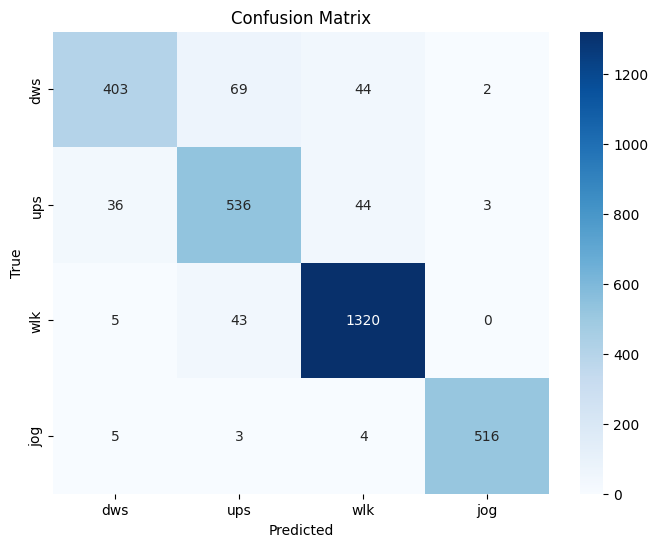

In [43]:
# After your final model training (or within cross-validation)
model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        xb = xb.permute(0, 2, 1)
        out = model(xb)
        all_preds.extend(out.argmax(1).cpu().numpy())
        all_true.extend(yb.cpu().numpy())

# Classification report
print("Classification Report:")
print(classification_report(all_true, all_preds, target_names=act_labels))

# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(all_true, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=act_labels, yticklabels=act_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

###Per-Class Metric Visualization

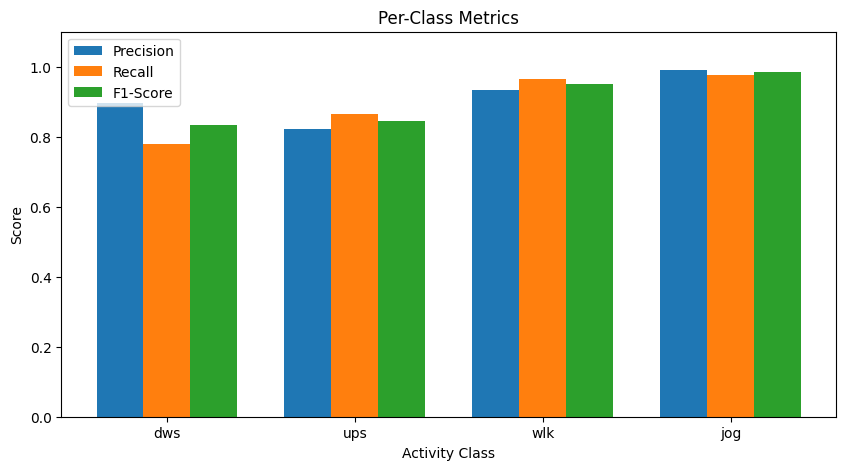

In [44]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate metrics per class
precision, recall, f1, _ = precision_recall_fscore_support(all_true, all_preds, average=None)

# Plot
plt.figure(figsize=(10, 5))
x = np.arange(len(act_labels))
width = 0.25

plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1-Score')

plt.xlabel('Activity Class')
plt.ylabel('Score')
plt.title('Per-Class Metrics')
plt.xticks(x, act_labels)
plt.legend()
plt.ylim(0, 1.1)
plt.show()

###Learning Curves (During Training)

Epoch 1: Train Loss: 0.2408, Val Loss: 0.1185
Train Acc: 0.9156, Val Acc: 0.9637
Epoch 2: Train Loss: 0.2341, Val Loss: 0.1239
Train Acc: 0.9177, Val Acc: 0.9578
Epoch 3: Train Loss: 0.2308, Val Loss: 0.1140
Train Acc: 0.9211, Val Acc: 0.9651
Epoch 4: Train Loss: 0.2264, Val Loss: 0.1109
Train Acc: 0.9167, Val Acc: 0.9647
Epoch 5: Train Loss: 0.2151, Val Loss: 0.0975
Train Acc: 0.9274, Val Acc: 0.9723
Epoch 6: Train Loss: 0.2162, Val Loss: 0.1021
Train Acc: 0.9242, Val Acc: 0.9674
Epoch 7: Train Loss: 0.2053, Val Loss: 0.0928
Train Acc: 0.9322, Val Acc: 0.9703
Epoch 8: Train Loss: 0.2013, Val Loss: 0.0996
Train Acc: 0.9301, Val Acc: 0.9670
Epoch 9: Train Loss: 0.2072, Val Loss: 0.0868
Train Acc: 0.9290, Val Acc: 0.9749
Epoch 10: Train Loss: 0.1892, Val Loss: 0.0728
Train Acc: 0.9348, Val Acc: 0.9733


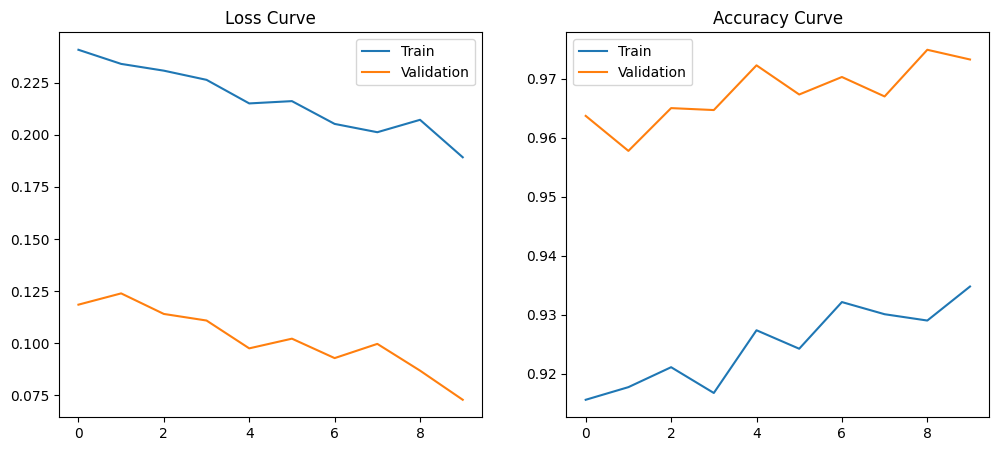

In [46]:
# Modified training loop with validation tracking
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(10):
    # Training phase
    model.train()
    epoch_loss = 0
    correct = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        xb = xb.permute(0, 2, 1)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        correct += (out.argmax(1) == yb).sum().item()

    train_losses.append(epoch_loss/len(train_loader))
    train_accs.append(correct/len(train_ds))

    # Validation phase
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for xb, yb in test_loader:  # Using test_loader as validation here
            xb, yb = xb.to(device), yb.to(device)
            xb = xb.permute(0, 2, 1)
            out = model(xb)
            val_loss += criterion(out, yb).item()
            correct += (out.argmax(1) == yb).sum().item()

    val_losses.append(val_loss/len(test_loader))
    val_accs.append(correct/len(test_ds))

    print(f"Epoch {epoch+1}: Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
    print(f"Train Acc: {train_accs[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}")

# Plot learning curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

###Subject-Wise Validation
#### Leave-One-Subject-Out (LOSO)
#####ensures generalization to new users

##### Updating Data Loading to preserve Subject IDs

In [48]:
def create_time_series(dt_list, act_labels, trial_codes, mode="raw", labeled=True):
    num_data_cols = len(dt_list) if mode == "mag" else len(dt_list * 3)
    dataset = np.zeros((0, num_data_cols + 2)) if labeled else np.zeros((0, num_data_cols + 1))  # +2 for label and subject

    ds_list = get_ds_infos()
    subject_ids = []

    for sub_id in ds_list["code"]:
        for act_id, act in enumerate(act_labels):
            for trial in trial_codes[act_id]:
                fname = f'A_DeviceMotion_data/{act}_{trial}/sub_{int(sub_id)}.csv'
                raw_data = pd.read_csv(fname).drop(['Unnamed: 0'], axis=1)

                vals = np.zeros((len(raw_data), num_data_cols))
                for x_id, axes in enumerate(dt_list):
                    if mode == "mag":
                        vals[:, x_id] = (raw_data[axes]**2).sum(axis=1)**0.5
                    else:
                        vals[:, x_id*3:(x_id+1)*3] = raw_data[axes].values

                if labeled:
                    lbls = np.array([[act_id]] * len(raw_data))
                    sub_ids = np.array([[sub_id]] * len(raw_data))  # Add subject IDs
                    vals = np.concatenate((vals[:, :num_data_cols], lbls, sub_ids), axis=1)

                dataset = np.append(dataset, vals, axis=0)
                subject_ids.extend([sub_id] * len(raw_data))

    cols = [col for axes in dt_list for col in (axes if mode == "raw" else [axes[0][:-2]])]
    if labeled:
        cols += ["act", "subject"]  # Add subject column

    return pd.DataFrame(data=dataset, columns=cols)

#####Updating windows creation fuction to preserve subject IDs

In [49]:
def windows(df, window_size=400, stride=200):
    X_windows = []
    y_windows = []
    subject_windows = []  # To store subject IDs for each window

    for i in range(0, len(df) - window_size, stride):
        window = df.iloc[i:i+window_size]
        if len(window['act'].unique()) == 1:
            X_windows.append(window.drop(columns=['act', 'subject']).values)
            y_windows.append(window['act'].iloc[0])
            subject_windows.append(window['subject'].iloc[0])  # All values same in window

    return np.array(X_windows), np.array(y_windows), np.array(subject_windows)

#####Updating 1D CNN model to handel variable input size

In [51]:
class CNN1D(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(CNN1D, self).__init__()

        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2)

        # Adaptive pooling to handle variable length
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)

        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.adaptive_pool(x)  # Shape: (batch, 128, 1)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        return self.fc2(x)

#####Implementing all imports and LOSO code

Using device: cpu
Input shape: (3649, 400, 6)
Label shape: (3649,)
Subjects: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24.]

Fold 1: Testing on subject 1.0
Epoch 1: Loss = 0.7585, Acc = 0.6760
Epoch 2: Loss = 0.4389, Acc = 0.8320
Epoch 3: Loss = 0.3128, Acc = 0.8929
Epoch 4: Loss = 0.2427, Acc = 0.9160
Epoch 5: Loss = 0.2283, Acc = 0.9214
Epoch 6: Loss = 0.1819, Acc = 0.9391
Epoch 7: Loss = 0.1546, Acc = 0.9473
Epoch 8: Loss = 0.1360, Acc = 0.9553
Epoch 9: Loss = 0.1104, Acc = 0.9653
Epoch 10: Loss = 0.1242, Acc = 0.9599

Subject 1.0 Results:
Accuracy: 0.6131
Confusion Matrix:
[[22  2  0  0]
 [ 1 28  1  0]
 [29 16  8  0]
 [ 2  0  2 26]]

Fold 2: Testing on subject 2.0
Epoch 1: Loss = 0.7880, Acc = 0.6654
Epoch 2: Loss = 0.4756, Acc = 0.8093
Epoch 3: Loss = 0.3557, Acc = 0.8671
Epoch 4: Loss = 0.2726, Acc = 0.9032
Epoch 5: Loss = 0.2235, Acc = 0.9237
Epoch 6: Loss = 0.2247, Acc = 0.9217
Epoch 7: Loss = 0.1643, Acc = 0.9437
Epoch 8: Los

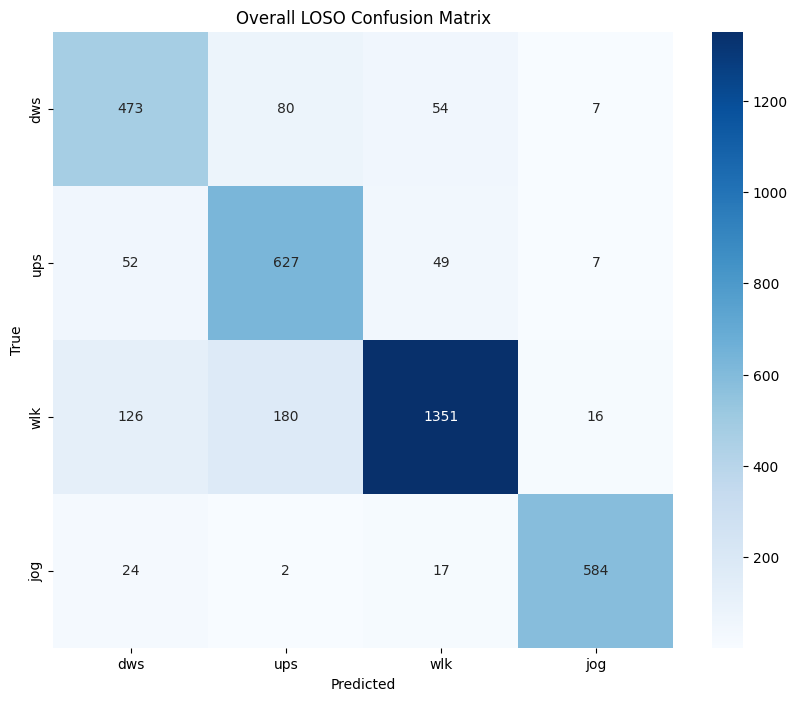

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset class
class MotionSenseDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load and prepare data
dataset = create_time_series(dt_list, act_labels, trial_codes, mode="raw", labeled=True)
X_raw, y_raw, subjects = windows(dataset)

# Verify shapes
print(f"Input shape: {X_raw.shape}")  # (num_windows, window_size, num_features)
print(f"Label shape: {y_raw.shape}")
print(f"Subjects: {np.unique(subjects)}")

# Initialize LOSO
logo = LeaveOneGroupOut()
subject_accuracies = []
confusion_matrices = []
criterion = nn.CrossEntropyLoss()

for fold, (train_idx, test_idx) in enumerate(logo.split(X_raw, y_raw, subjects)):
    current_subject = subjects[test_idx[0]]
    print(f"\nFold {fold + 1}: Testing on subject {current_subject}")

    # Split data
    X_train, X_test = X_raw[train_idx], X_raw[test_idx]
    y_train, y_test = y_raw[train_idx], y_raw[test_idx]

    # Create datasets and loaders
    train_ds = MotionSenseDataset(X_train, y_train)
    test_ds = MotionSenseDataset(X_test, y_test)
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

    # Initialize model
    model = CNN1D(input_channels=X_train.shape[2],
                 num_classes=len(np.unique(y_train))).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training
    for epoch in range(10):
        model.train()
        epoch_loss = 0
        correct = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            xb = xb.permute(0, 2, 1)  # Shape: (batch, channels, timesteps)

            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            correct += (out.argmax(1) == yb).sum().item()

        train_acc = correct / len(train_ds)
        print(f"Epoch {epoch+1}: Loss = {epoch_loss/len(train_loader):.4f}, Acc = {train_acc:.4f}")

    # Evaluation
    model.eval()
    all_preds, all_true = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            xb = xb.permute(0, 2, 1)
            out = model(xb)
            all_preds.extend(out.argmax(1).cpu().numpy())
            all_true.extend(yb.cpu().numpy())

    # Calculate metrics
    acc = accuracy_score(all_true, all_preds)
    subject_accuracies.append(acc)
    cm = confusion_matrix(all_true, all_preds)
    confusion_matrices.append(cm)

    print(f"\nSubject {current_subject} Results:")
    print(f"Accuracy: {acc:.4f}")
    print("Confusion Matrix:")
    print(cm)

# Final results
print("\n" + "="*50)
print("LOSO Validation Complete")
print(f"Mean Accuracy: {np.mean(subject_accuracies):.4f} ± {np.std(subject_accuracies):.4f}")
print("\nPer-Subject Accuracies:")
for subj, acc in zip(np.unique(subjects), subject_accuracies):
    print(f"Subject {subj}: {acc:.4f}")

# Plot overall confusion matrix
overall_cm = sum(confusion_matrices)
plt.figure(figsize=(10, 8))
sns.heatmap(overall_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=act_labels, yticklabels=act_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Overall LOSO Confusion Matrix')
plt.show()